<a href="https://colab.research.google.com/github/kvamsi7/mscs/blob/main/CS5720-Neural%20Network%20and%20Deep%20Learning/NN_Final_Project/NNDL_Project_71.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Restaurant_Reviews.tsv to Restaurant_Reviews.tsv


In [24]:
import numpy as np
import pandas as pd
import re
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Embedding, LSTM, Flatten,Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Load dataset
dataset = pd.read_csv('Restaurant_Reviews.tsv', delimiter='\t', quoting=3)


In [5]:
# Preprocess the text data

def pre_processing_text(data):
  corpus = []
  for i in range(len(data)):
      review = re.sub('[^a-zA-Z]', ' ', data[i])
      review = review.lower().split()
      review = [word for word in review if word not in set(stopwords.words('english'))]
      review = ' '.join(review)
      corpus.append(review)
  return corpus

corpus = pre_processing_text(dataset['Review'])
# Convert labels to binary
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dataset['Liked'])

# # Transform text data to numerical vectors
# cv = CountVectorizer(max_features=1500)
# X = cv.fit_transform(corpus).toarray()

In [28]:
max_features = 1500
max_len = 100
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(corpus)
X = tokenizer.texts_to_sequences(corpus)

X = pad_sequences(X,maxlen=max_len)

In [53]:
# saving tokenizer
import pickle
tokenizer_path = 'tokenizer.pkl'
pickle.dump(tokenizer,open(tokenizer_path,'wb'))

In [29]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# # Reshape input data for LSTM
# X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [30]:
from keras.layers import Layer
import keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [66]:
# Define LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(max_features, 256,input_length = max_len))
lstm_model.add(LSTM(units=196, dropout=0.2,return_sequences=True))
lstm_model.add(Bidirectional(LSTM(units=128,recurrent_dropout=0.2)))
# lstm_model.add(Attention())  # Add the custom attention layer after LSTM
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [67]:

# callback
callback = EarlyStopping(monitor='loss',patience=3)
# Train LSTM model
lstm_model.fit(X_train, y_train, epochs=25, batch_size=32, callbacks = [callback],verbose=1)


Epoch 1/25
25/25 [==============================] - 31s 939ms/step - loss: 0.6944 - accuracy: 0.4988
Epoch 2/25
25/25 [==============================] - 22s 901ms/step - loss: 0.6937 - accuracy: 0.5050
Epoch 3/25
25/25 [==============================] - 23s 881ms/step - loss: 0.6933 - accuracy: 0.5050
Epoch 4/25
25/25 [==============================] - 23s 915ms/step - loss: 0.6872 - accuracy: 0.5688
Epoch 5/25
25/25 [==============================] - 24s 983ms/step - loss: 0.6491 - accuracy: 0.6687
Epoch 6/25
25/25 [==============================] - 22s 886ms/step - loss: 0.4779 - accuracy: 0.8037
Epoch 7/25
25/25 [==============================] - 23s 915ms/step - loss: 0.2914 - accuracy: 0.8813
Epoch 8/25
25/25 [==============================] - 23s 928ms/step - loss: 0.2101 - accuracy: 0.9212
Epoch 9/25
25/25 [==============================] - 23s 928ms/step - loss: 0.1460 - accuracy: 0.9450
Epoch 10/25
25/25 [==============================] - 23s 931ms/step - loss: 0.1364 - accura

In [68]:

# Evaluate LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
print("LSTM Test Accuracy:", lstm_accuracy)


7/7 [==============================] - 2s 174ms/step - loss: 1.4395 - accuracy: 0.7100
LSTM Test Accuracy: 0.7099999785423279


In [69]:
# Predict sentiment for a new review using both models
input_text = ['Place is good but the food is worst']
# input_vector = cv.transform(input_text).toarray()
input_vector_test = tokenizer.texts_to_sequences(input_text)

input_vector_seq = pad_sequences(input_vector_test,maxlen=max_len)

# LSTM model prediction
lstm_prediction = lstm_model.predict(input_vector_seq)[0][0]
if lstm_prediction >= 0.5:
    print('LSTM: Review is Positive')
else:
    print('LSTM: Review is Negative')

1/1 [==============================] - 1s 1s/step
LSTM: Review is Negative


In [70]:
y_pred = np.array([1 if y_p > 0.5 else 0 for y_p in lstm_model.predict(X_test)])

7/7 [==============================] - 1s 166ms/step


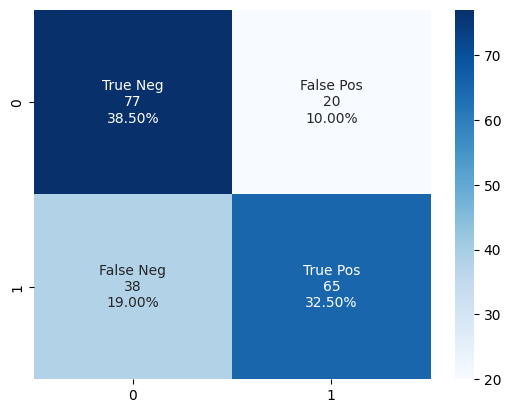

In [71]:
cf_matrix = confusion_matrix(y_test,y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
plt.show()

In [72]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.79      0.73        97
           1       0.76      0.63      0.69       103

    accuracy                           0.71       200
   macro avg       0.72      0.71      0.71       200
weighted avg       0.72      0.71      0.71       200



In [13]:
models_performance = {}
def update_model_performance(dictionary, model_name, parameters, accuracy, other_metrics):
    """
    Update the dictionary with model performance metrics.

    Args:
    dictionary (dict): The dictionary to update.
    model_name (str): The name of the model.
    parameters (dict): A dictionary of the model's parameters.
    accuracy (float): The accuracy of the model on the test set.
    other_metrics (dict): Other relevant metrics (like F1-score, precision, recall).

    Returns:
    None; updates the dictionary in place.
    """
    if model_name in dictionary:
        print(f"Model {model_name} already exists in the dictionary. Updating the existing entry.")
    else:
        print(f"Adding new model {model_name} to the dictionary.")

    dictionary[model_name] = {
        'Parameters': parameters,
        'Accuracy': accuracy,
        'Other Metrics': other_metrics
    }


In [73]:
# Example usage:
update_model_performance(models_performance, 'LSTM without attention and optimizer as rmsprop', {'units': 256, 'dropout': 0.2, 'recurrent_dropout': 0.2},lstm_accuracy, {'F1 Score': 0.71, 'Recall': 0.71, 'Precision': 0.72})

Adding new model LSTM without attention and optimizer as rmsprop to the dictionary.


In [74]:
pd.DataFrame(models_performance).T.reset_index()

,index,Parameters,Accuracy,Other Metrics
0,LSTM with Single Embedding layer,"{'units': 256, 'dropout': 0.5, 'recurrent_drop...",0.735,"{'F1 Score': 0.73, 'Recall': 0.73, 'Precision'..."
1,LSTM with Bidirectional layer,"{'units': 256, 'dropout': 0.2, 'recurrent_drop...",0.73,"{'F1 Score': 0.73, 'Recall': 0.73, 'Precision'..."
2,LSTM without attention,"{'units': 256, 'dropout': 0.2, 'recurrent_drop...",0.71,"{'F1 Score': 0.73, 'Recall': 0.73, 'Precision'..."
3,LSTM without attention and optimizer as adadelta,"{'units': 256, 'dropout': 0.2, 'recurrent_drop...",0.515,"{'F1 Score': 0.73, 'Recall': 0.73, 'Precision'..."
4,LSTM without attention and optimizer as rmsprop,"{'units': 256, 'dropout': 0.2, 'recurrent_drop...",0.71,"{'F1 Score': 0.71, 'Recall': 0.71, 'Precision'..."


In [52]:
lstm_model.save("model_lstm_73.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


|level\_0|index|Parameters|Accuracy|Other Metrics|
|---|---|---|---|---|
|0|LSTM with Single Embedding layer|\{'units': 256, 'dropout': 0\.5, 'recurrent\_dropout': 0\.2\}|0\.735|\{'F1 Score': 0\.73, 'Recall': 0\.73, 'Precision': 0\.73\}|
|1|LSTM with Bidirectional layer|\{'units': 256, 'dropout': 0\.2, 'recurrent\_dropout': 0\.2\}|0\.7300000190734863|\{'F1 Score': 0\.73, 'Recall': 0\.73, 'Precision': 0\.73\}|
|2|LSTM without attention|\{'units': 256, 'dropout': 0\.2, 'recurrent\_dropout': 0\.2\}|0\.7099999785423279|\{'F1 Score': 0\.73, 'Recall': 0\.73, 'Precision': 0\.73\}|
|3|LSTM without attention and optimizer as adadelta|\{'units': 256, 'dropout': 0\.2, 'recurrent\_dropout': 0\.2\}|0\.5149999856948853|\{'F1 Score': 0\.73, 'Recall': 0\.73, 'Precision': 0\.73\}|
|4|LSTM without attention and optimizer as rmsprop|\{'units': 256, 'dropout': 0\.2, 'recurrent\_dropout': 0\.2\}|0\.7099999785423279|\{'F1 Score': 0\.71, 'Recall': 0\.71, 'Precision': 0\.72\}|